In [3]:
import numpy as np
from numpy import ndarray
from typing import Callable,Dict,Tuple, List
import matplotlib.pyplot as plt

In [8]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
def mae(y_obs:ndarray,y_pred:ndarray)->float:
    return np.mean(np.abs(y_obs-y_pred))

In [5]:
def RsS(y_obs:ndarray,y_pred:ndarray)->float:
    return np.sum(np.power(y_obs-y_pred,2))

In [6]:
def mse(y_obs:ndarray,y_pred:ndarray)->float:
    return RsS(y_obs,y_pred)/(len(y_pred))

In [7]:
def rmse(y_obs:ndarray,y_pred:ndarray)-> float:
    return np.sqrt(mse(y_obs,y_pred))

In [8]:
def Ridge_RegresS(S:ndarray,y:ndarray,weights:Dict[str,ndarray],delta:float = 3.)-> Tuple[float,Dict[str,ndarray]]:
    assert S.shape[0] == y.shape[0]
    assert S.shape[1] == weights['W'].shape[0]
    assert weights['K'].shape[0] == weights['K'].shape[1]
    
    f1 = np.dot(S,weights['W'])
    f2 = f1 + weights['K']
    f3 = RsS(y,f2) + delta*np.sum(np.power(weights['W'],2))
    
    forward_info:Dict[str,ndarray] = {}
    forward_info['S'] = S
    forward_info['f1'] = f1
    forward_info['f2'] = f2
    forward_info['delta'] = delta
    forward_info['y'] = y
    
    return f3, forward_info

In [9]:
def to_2d_tensor(s:ndarray, type:str = "col")-> ndarray:
    assert s.ndim == 1
    
    if type == "col":
        return s.reshape(-1,1)
    elif type == "row":
        return s.reshape(1,-1)

In [10]:
def permute_data(S:ndarray, w:ndarray):
    perm = np.random.permutation(S.shape[0])
    return S[perm], w[perm]

In [11]:
def grads(forward_info:Dict[str,ndarray], weights:Dict[str,ndarray]) -> Dict[str,ndarray]:
    
    grad_W = -2*np.dot(np.transpose(forward_info['S']),forward_info['y']-forward_info['f2'])+2*forward_info['delta']*weights['W']
    partial_der_k = -2*np.sum(forward_info['y'] - forward_info['f2'])
    
    grads:Dict[str,ndarray] = {'W':grad_W,'K':partial_der_k}
        
    return grads

In [12]:
Batch = Tuple[ndarray,ndarray]

def generate_batch(S:ndarray, w:ndarray, start: int = 0, batch_size: int = 50)-> Batch:
    assert S.ndim == w.ndim == 2
    
    if start + batch_size > S.shape[0]:
        batch_size = S.shape[0] - start
        
    S_batch, w_batch = S[start:batch_size], w[start:batch_size]
    
    return S_batch, w_batch

In [13]:
def forward_loss(S:ndarray,y:ndarray, weights:Dict[str,ndarray],delta:float = 3.)-> Tuple[Dict[str,ndarray], float]:
    
    f1 = np.dot(S,weights['W'])
    
    f2 = f1 + weights['K']
    
    f3 = RsS(y,f2) + delta*np.sum(np.power(weights['W'],2))
    
    forward_info: Dict[str,ndarray] = {}
    forward_info['S'] = S
    forward_info['f1'] = f1
    forward_info['f2'] = f2
    forward_info['y'] = y
    forward_info['delta'] = delta
    
    return forward_info, f3

In [25]:
def initializing_weights(dim_in:int)->Dict[str,ndarray]:
    
    weights:Dict[str,ndarray] = {}
    W = np.random.randn(dim_in,1)
    K = np.random.randn(1,1)
    
    weights['W'] = W
    weights['K'] = K
    
    return weights

In [4]:
def train(S:ndarray,y:ndarray, n_iter: int = 1000, learning_rate = .01, batch_size:int = 100, 
         return_losses:bool = False, return_weights: bool = True)-> None:
    start = 0
    
    weights = initializing_weights(S.shape[1])
    
    S,y = permute_data(S,y)
    
    if return_losses:
        losses = []
        
    for i in range(n_iter):
        if start >= S.shape[0]:
            S,y = permute_data(S,y)
            start = 0
            
        S_batch, y_batch = generate_batch(S,y,start,batch_size)
        start += batch_size
        
        forward_info, loss = forward_loss(S_batch,y_batch,weights)
        
        if return_losses:
            losses.append(loss)
            
        loss_grads = grads(forward_info,weights)
        
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
            
    if return_weights:
        return losses.weights
    
    return None

In [48]:
boston = load_boston()

In [49]:
data = boston.data
target = boston.target

In [50]:
data[:3]


array([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01,
        6.5750e+00, 6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02,
        1.5300e+01, 3.9690e+02, 4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9690e+02, 9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        7.1850e+00, 6.1100e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9283e+02, 4.0300e+00]])

In [51]:
h = StandardScaler()
data  = h.fit_transform(data)

In [52]:
target[7],data[1]

(27.1, array([-0.41733926, -0.48772236, -0.59338101, -0.27259857, -0.74026221,
         0.19427445,  0.36716642,  0.55715988, -0.8678825 , -0.98732948,
        -0.30309415,  0.44105193, -0.49243937]))

In [53]:
target = to_2d_tensor(target)

In [54]:
target.ndim

2

In [55]:
train_data,test_data,train_target,test_target = train_test_split(data,target,train_size = .8,random_state =91221)


D:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [100]:
train_info = train(train_data,train_target,delta = 1.,n_iter=1000, learning_rate = .001, batch_size= 20,
         return_losses = True,return_weights = True)

In [101]:
train_info

([9036.765103978032,
  42.46816630624242,
  41.96007716455453,
  41.4580668013578,
  40.96206249014635,
  40.47199237451425,
  39.98778545774556,
  39.509371592529085,
  39.03668147079607,
  38.569646613679474,
  38.108199361593414,
  37.65227286443131,
  37.20180107188125,
  36.75671872385726,
  36.31696134104503,
  35.88246521556077,
  35.4531674017218,
  35.029005706927606,
  34.609918682649926,
  34.1958456155307,
  33.78672651858649,
  8242.513933173324,
  34.3854971220625,
  33.97410903449415,
  33.56764279400545,
  33.166039515617975,
  32.76924101885312,
  32.37718981930356,
  31.989829120305416,
  31.60710280471008,
  31.228955426754524,
  30.855332204028834,
  30.48617900953984,
  30.121442363869704,
  29.76106942742836,
  29.405007992798613,
  29.053206477172772,
  28.705613914879876,
  28.362179950002258,
  28.02285482908043,
  27.687589393905306,
  27.356335074396625,
  7546.167023845818,
  28.621153867365333,
  28.27873038249617,
  27.940403652199983,
  27.606124662905053

In [102]:
loss = train_info[0]

In [103]:
weights = train_info[1]

In [104]:
weights

{'W': array([[-0.46280722],
        [ 0.04558309],
        [-0.25148204],
        [ 0.35938782],
        [-0.26195474],
        [ 0.33155173],
        [-0.45798039],
        [ 0.31526155],
        [-0.34132837],
        [-0.51240366],
        [-0.37367135],
        [ 0.28954784],
        [-0.40846484]]), 'K': array([[16.60266849]])}

In [105]:
loss

[9036.765103978032,
 42.46816630624242,
 41.96007716455453,
 41.4580668013578,
 40.96206249014635,
 40.47199237451425,
 39.98778545774556,
 39.509371592529085,
 39.03668147079607,
 38.569646613679474,
 38.108199361593414,
 37.65227286443131,
 37.20180107188125,
 36.75671872385726,
 36.31696134104503,
 35.88246521556077,
 35.4531674017218,
 35.029005706927606,
 34.609918682649926,
 34.1958456155307,
 33.78672651858649,
 8242.513933173324,
 34.3854971220625,
 33.97410903449415,
 33.56764279400545,
 33.166039515617975,
 32.76924101885312,
 32.37718981930356,
 31.989829120305416,
 31.60710280471008,
 31.228955426754524,
 30.855332204028834,
 30.48617900953984,
 30.121442363869704,
 29.76106942742836,
 29.405007992798613,
 29.053206477172772,
 28.705613914879876,
 28.362179950002258,
 28.02285482908043,
 27.687589393905306,
 27.356335074396625,
 7546.167023845818,
 28.621153867365333,
 28.27873038249617,
 27.940403652199983,
 27.606124662905053,
 27.275844987438063,
 26.949516778008356,
 26

In [106]:
def predict(S:ndarray, weights:Dict[str,ndarray]):
    return (np.dot(S,weights['W']) + weights['K'])

In [107]:
test_pred_target = predict(test_data, weights)

In [108]:
(test_pred_target, test_target)

(array([[14.87553098],
        [15.82229233],
        [15.74995603],
        [18.33886205],
        [19.43168075],
        [18.36704472],
        [16.36857587],
        [15.17026195],
        [16.54450436],
        [15.30219196],
        [14.81399972],
        [18.68823486],
        [15.07335713],
        [20.26866204],
        [14.73495555],
        [11.84531548],
        [15.27380519],
        [15.62155744],
        [17.07061958],
        [12.46767099],
        [16.56527167],
        [19.63749026],
        [20.16443033],
        [16.19499208],
        [19.92688394],
        [18.26720589],
        [16.09203338],
        [19.22326808],
        [16.03952618],
        [20.86650725],
        [12.63337571],
        [15.82178016],
        [15.05885131],
        [19.6829982 ],
        [12.56066455],
        [17.3452031 ],
        [18.29583268],
        [ 9.8224043 ],
        [19.12935829],
        [18.24251444],
        [14.50169452],
        [16.75619443],
        [18.55751928],
        [18

In [109]:
mse(test_target,test_pred_target)

97.15527939320265

In [66]:
rmse(test_target,test_pred_target)

7.992766376405729

In [66]:
train_pred_target = predict(train_data,weights)

In [69]:
mse(train_target,train_pred_target)

33.67890322641527

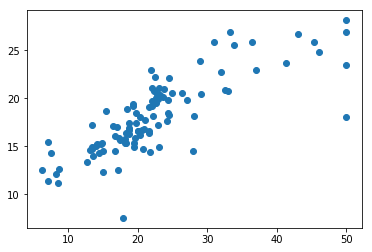

In [71]:
plt.scatter(test_target,test_pred_target)

In [67]:
mae(train_target,train_pred_target)

3.960220909737897

In [68]:
mae(test_target,test_pred_target)

4.472909684323301